In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Data

In [11]:
#SVM, real data
#Pas cst

def load_diabetic_retinopathy(filename, minidata=False):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'diabeticRetinopathy.csv'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    http://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set
    """

    data = np.loadtxt(filename, delimiter=',')

    y = data[:, -1] * 2 - 1
    X = data[:, :-1]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y

X, y = load_diabetic_retinopathy('diabeticRetinopathy.csv', minidata=False)
N = X.shape[0]
d = X.shape[1]
X = np.concatenate((X, np.ones((N,1))), axis=1)
N = X.shape[0]
d = X.shape[1]
X = X[0:1000,:]
N = X.shape[0]
d = X.shape[1]
print (N,d)

(1000, 20)


In [21]:
g = 9

Groups = np.zeros((9,200))
for i in range(9):
    Groups[i] = list(xrange(i*100,i*100 + 200))
Groups = Groups.astype(int)    

In [22]:
Groups.shape

(9, 200)

In [28]:
def H(z, y, X):
    return 1 / float(N) * sum([max(0,1-y[j]*np.dot(z,X[j])) for j in range(N)])

def G(z):
    return sum([np.linalg.norm(z[Groups[j]]) for j in range(Groups.shape[0])])

def F(z, y, X, lambd = 1.0):
    return H(z, y, X) + lambd * G(z)

def P(x, pas = 1):
    return min(x + pas,max(x,1))

def Q(x, pas = 1):
    alpha = max(0, 1 - pas/np.linalg.norm(x))
    return alpha*x

def projomega(Y, pas = 1.0):
    (a,b) = Y.shape
    Z = np.zeros((a,b))
    for j in range(b):
        for i in Groups[j,:]:
            Z[i,j] = Y[i,j]
    for j in range(b):
        norm = np.linalg.norm(Z[:,j])
        if norm > pas:
            Z[:,j] = Z[:,j]*pas/norm
    return Z

def proxolp(u, N, g, it = 10, pas = 1.0): 
    Y = np.zeros((N,g))
    Xn = np.copy(Y)
    e = np.ones(g)
    for n in range(it):
        Z = Y + 1/(2*float(g))*np.outer(np.maximum(0,u-np.dot(Y,e)),e)
        X = projomega(Z, pas)
        Y = X + (n/float(n+3))*(X - Xn)
        Xn = X
    return np.maximum(0,u-np.dot(Y,e))

u = np.random.randn(N)
proxolp(u, N, g, it = 10).shape

(1000,)

In [30]:
z0 = 5.0 * np.random.randn(d)

r = 3.0
size = 200
many_random_sample = 10
subsample = 1
lambd = 1.0

np.linalg.norm(z0[Groups[2]])
#F(z0, y, X, lambd)

IndexError: index 200 is out of bounds for axis 1 with size 20

In [185]:
#On veut calculer le prox du group lasso de groupe Groups
lgr = 100


feature = np.random.randn(N*lgr)
feature = np.reshape(feature,(N,lgr))
label = np.random.choice([-1,1],lgr)

def f(x,lgr):
    a = sum([V(label[i] * np.dot(x,feature[:,i])) for i in range(lgr)])
    b = sum([norm2g(x,Groups[i,:]) for i in range(99)])
    return a+b
    

x_0 = np.random.randn(N)

In [239]:
#Stodr

gamma = 0.1

x = np.copy(x_0)

Result = [f(x,lgr)]
Time = [0]

t = 0
for k in range(200):
    while t < 0.02 :
        i = np.random.randint(lgr)
        phi = label[i]*feature[:,i]
        tip = time.time()
        phix = np.dot(phi, x)
        y = x - (phix - P(phix, gamma))/(np.linalg.norm(x)*np.linalg.norm(x))*phi
        j = np.random.randint(99)
        z = Q(2*y - x, Groups[j:][0], gamma)
        x = x + z - y
        top = time.time()
        t += top - tip
    #print (k)
    Result +=[f(x,lgr)]
    Time += [t + Time[-1]]
    t = 0

Time[-1]
print (x)
x1 = x

[ 0.01043397 -0.00108909 -0.00376386 ..., -0.01362268  0.02380409
  0.01310346]


In [205]:
lgr

100

In [240]:
#FoG-Lasso    

gamma1 = 0.1
x = np.copy(x_0)

Result_FoG = [f(x,lgr)]
Time_FoG = [0]

for i in range(20):
    phi = label[i]*feature[:,i]
    tip = time.time()
    phix = np.dot(phi, x)
    y = x - (phix - P(phix, gamma1))/(np.linalg.norm(x)*np.linalg.norm(x))*phi
    z = proxolp(2*y - x, N, 99, 10)
    x = x + z - y
    top = time.time()
    Result_FoG +=[f(x,lgr)]
    Time_FoG += [(top - tip) + Time_FoG[-1]]
    
print (x)

[ 0.01861134  0.01828995  0.16850166 ...,  0.06009859  0.0383093
  0.20733758]


In [233]:
Result[-1], Result_FoG[-1]

(33.420927796999756, 418.25451081810087)

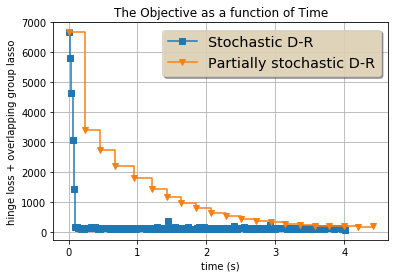

In [242]:
%matplotlib inline

dr = plt.plot(Time,Result,drawstyle='steps-post',marker = 's',label='Stochastic D-R')
fog = plt.plot(Time_FoG,Result_FoG,drawstyle='steps-post',marker = 'v',label='Partially stochastic D-R')

plt.xlabel('time (s)')
plt.ylabel('hinge loss + overlapping group lasso')
plt.title('The Objective as a function of Time')
legend = plt.legend(loc = 0, shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('#efe2c1')
#plt.axis([0, 75, 1000, 4500])
#plt.xscale('log')
plt.grid()
plt.savefig('stodr-6.png')
plt.show()
